In [62]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import fibsem
from fibsem.imaging import masks
from fibsem.imaging import utils   
from autoscript_sdb_microscope_client.structures import AdornedImage
from PIL import Image
import logging
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import imageio
import cv2
import glob
import itertools
import pandas as pd
from pprint import pprint
import plotly.express as px
import statsmodels
import ipywidgets
from dataclasses import dataclass
from skimage.feature import match_template
import skimage
import kymatio
from kymatio.numpy import Scattering2D
from kymatio.numpy import Scattering1D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Create dictionary for IB images, sort by grid position, field with (img stack), and corresponding name/img position
dict1 = {}
dict2 = {}
dict3 = {}
grid_poses = ["000.000", "000.001", "000.002", "001.000", "001.001", "001.002", "002.000", "002.001", "002.002"]
hfws = ["8", "15", "20", "30", "50"]
names = ["base", "diag_down", "diag_up", "start"]
for grid_pos in grid_poses:
    dict1[grid_pos] = {}
    dict2[grid_pos] = {}
    for hfw in hfws:
        dict1[grid_pos][hfw] = {}
        dict2[grid_pos][hfw] = {}
        for name in names:
            fname1 = glob.glob(f"../../../mapping_2022-09-27.01-18-18PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            fname2 = glob.glob(f"../../../mapping_2022-09-27.02-59-50PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img1 = mpimg.imread(fname1)
            img2 = mpimg.imread(fname2)
            dict1[grid_pos][hfw][name] = img1
            dict2[grid_pos][hfw][name] = img2
for grid_pos in ["000.000", "000.001", "001.000", "001.001"]:
    dict3[grid_pos] = {}
    for hfw in hfws:
        dict3[grid_pos][hfw] = {}
        for name in names:
            fname3 = glob.glob(f"../../../mapping_2022-09-27.04-26-12PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img3 = mpimg.imread(fname3)
            dict3[grid_pos][hfw][name] = img3
# Create dictionary for Fluorescence images, sort by grid position (tile) and exposure times
# Additionally, transpose and crop the image array to the right IB image size.
fluor1 = {}
fluor2 = {}
fluor3 = {}
tiles = ["0.0", "0.1", "0.2", "1.0", "1.1", "1.2", "2.0", "2.1", "2.2"]
exposures = ["350", "500"]
for tile in tiles:
    fluor1[tile] = {}
    fluor2[tile] = {}
    for exposure in exposures:
        file1 = glob.glob(f"../../../mapping_2022-09-27.01-18-18PM/fluro/{tile}*{exposure}*.tiff")[0]
        file2 = glob.glob(f"../../../mapping_2022-09-27.02-59-50PM/fluro/{tile}*{exposure}*.tiff")[0]
        img1 = mpimg.imread(file1)
        img2 = mpimg.imread(file2)
        # Flip Vertical and crop to (1024,1536) same size as IB
        temp1 = np.flip(img1[512:1536, 256:1792], axis=0)
        temp2 = np.flip(img2[512:1536, 256:1792], axis=0)
        temp1_fft = np.fft.fftshift(np.fft.fft2(temp1))
        temp2_fft = np.fft.fftshift(np.fft.fft2(temp2))
        # New array to adjust for same pixelsize in both images!
        # Create array of dimension (x,y)/pixelratio with pixelratio here ~1.053
        mat1 = np.ndarray((972, 1458), dtype=np.complex128)
        mat2 = np.ndarray((972, 1458), dtype=np.complex128)
        # Create new array and crop s.t. middle point (highest value and 0 imaginary part) is preserved
        # Here x: 1024 -> 972 and y: 1536 -> 1458 meaning 52/2 and 78/2 respectively less at each edge
        mat1[:,:] = temp1_fft[26:26+972, 39:39+1458]
        mat2[:,:] = temp2_fft[26:26+972, 39:39+1458]
        fluor1[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat1)))
        fluor2[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat2)))
for tile in ["0.0", "0.1", "1.0", "1.1"]:
    fluor3[tile] = {}
    for exposure in exposures:
        file3 = glob.glob(f"../../../mapping_2022-09-27.04-26-12PM/fluro/{tile}*{exposure}*.tiff")[0]
        img3 = mpimg.imread(file3)
        temp3 = np.flip(img3[512:1536, 256:1792], axis=0)
        temp3_fft = np.fft.fftshift(np.fft.fft2(temp3))
        mat3 = np.ndarray((972, 1458), dtype=np.complex128)
        mat3[:,:] = temp3_fft[26:26+972, 39:39+1458]
        fluor3[tile][exposure] = np.abs(np.fft.ifft2(np.fft.ifftshift(mat3)))

In [15]:
def bp_mask(image_shape: tuple,
                 bandpass_outer_radius: int,
                 bandpass_inner_radius: int = 0,
                 bandpass_sigma: float = None):

    bandpass_mask = np.zeros(image_shape)
    r, c = np.array(image_shape) / 2
    inner_circle_rr, inner_circle_cc = skimage.draw.disk(
        (r, c), bandpass_inner_radius, shape=image_shape)
    outer_circle_rr, outer_circle_cc = skimage.draw.disk(
        (r, c), bandpass_outer_radius, shape=image_shape)
    bandpass_mask[outer_circle_rr, outer_circle_cc] = 1.0
    bandpass_mask[inner_circle_rr, inner_circle_cc] = 0.0
    bandpass_mask = np.array(bandpass_mask)
    # fourier space origin should be in the corner
    bandpass_mask = np.roll(bandpass_mask,
                            (np.array(image_shape) / 2).astype(int),
                            axis=(0, 1))
    # Soft edges help avoid ringing artifacts in results
    if bandpass_sigma is not None:
        bandpass_mask = skimage.filters.gaussian(bandpass_mask.astype(float),
                                                 sigma=bandpass_sigma)
    return bandpass_mask

def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    # zero_array = np.zeros(norm.shape)
    # final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return norm

def radial_spec(image: np.array):
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    R = np.sqrt(x ** 2 + y ** 2)
    f = lambda r: image[(R >= r - .5) & (R < r + .5)].mean()
    r = np.linspace(0, 824, num = 824)
    mean = np.vectorize(f)(r)
    return r, mean

In [17]:
# Crop images to make them square, here size (824, 824)
ib_crop = []
fl_crop = []
for i, j in zip(grid_poses, tiles):
    ib2 = dict2[i]["50"]["start"][100:924, 356:1180]
    fl2 = fluor2[j]["350"][74:898, 317:1141]
    ib_crop.append(ib2)
    fl_crop.append(fl2) 
for k, l in zip((["000.000", "000.001", "001.000", "001.001"]), (["0.0", "0.1", "1.0", "1.1"])):
    ib3 = dict3[k]["50"]["start"][100:924, 356:1180]
    fl3 = fluor3[l]["350"][74:898, 317:1141]
    ib_crop.append(ib3)
    fl_crop.append(fl3)

In [70]:
len(ib_crop)

13

In [38]:
scattering = Scattering2D(J=2, shape=(824, 824))

In [55]:
scat = scattering(fl_crop[0])

In [57]:
scat.shape

(81, 206, 206)

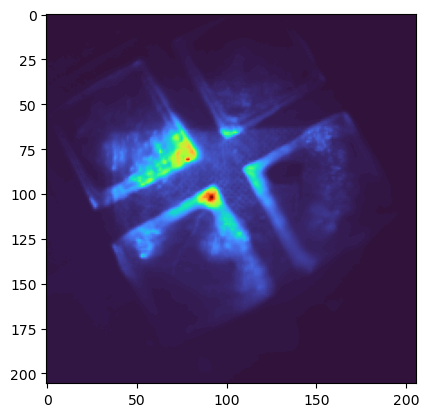

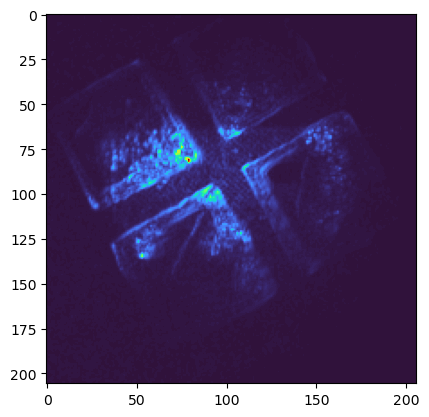

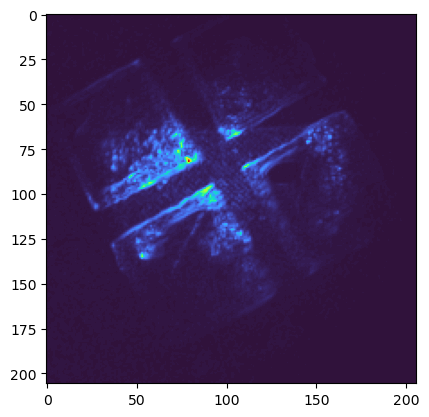

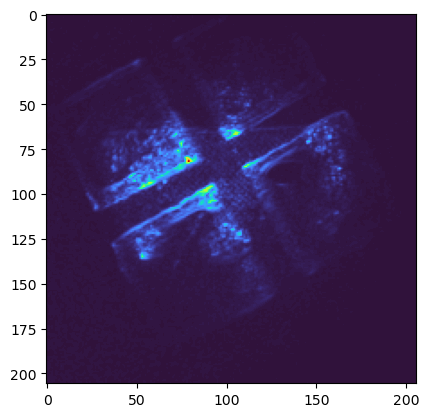

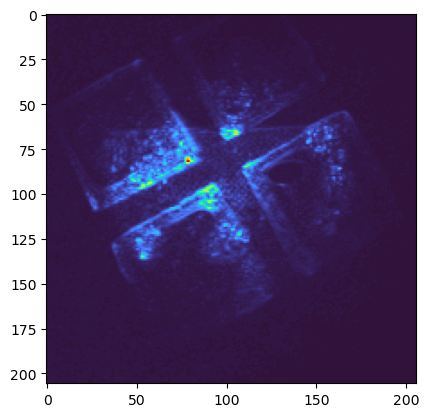

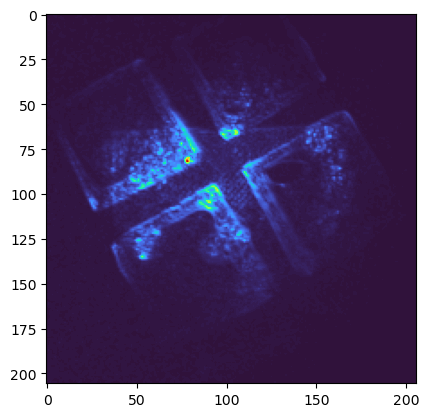

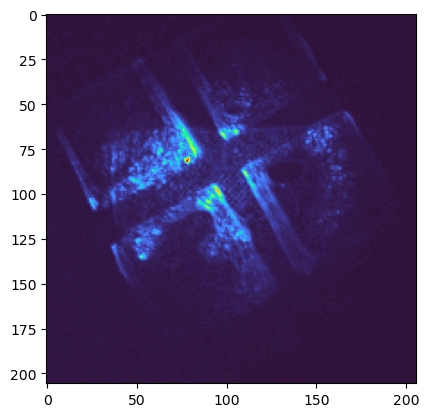

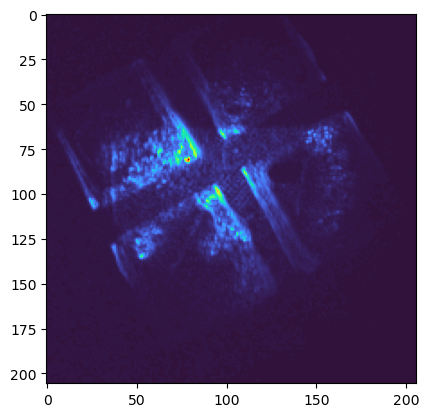

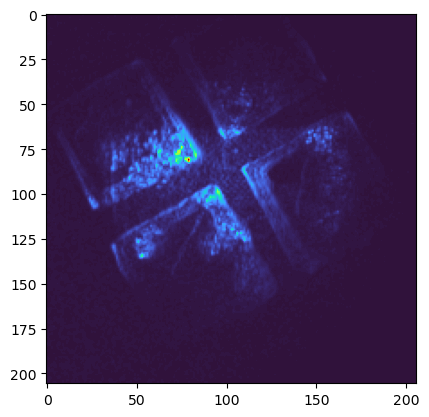

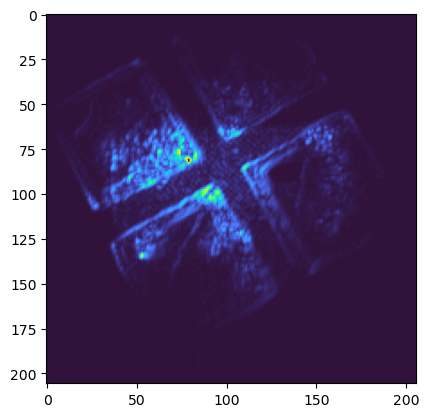

In [68]:
for i in range(10):
    plt.imshow(scat[i], cmap='turbo')
    plt.show()